# Brief overview - Network optimization and causal analysis for pertub-seq (NOCAP)

We want to be able to identify key regulatory genes, predict off target effects, find optimal pertubations, and refine/update existing network models. 

To do this, we are building a tool to integrate genome-scale network models, perturbation data, and emerging causal inference/ML methods. 

\
Our approach is broken into a few areas:

1. Data structure interface
   - genome-scale database (biocyc)
   - network representation (networkX, mixed graphs)
   - systems biology model (SBML)
   - structural equation models (sympy, y0)
   - probablistic models (mira, pyciemss) 

2. Modeling interface
   - Linear and non-linear models
   - forward simulation 
   - model calibration
   - causal analysis

3. Visualization (Mridula)


link: https://github.com/CRISPR-CARB/nocap/tree/12-grn-dag-to-sbml

# Update 8/28

Previously I showed:
- taking data from the biocyc database and converting into a network and then into a linear structural causal model
- simulating the models
- estimating model parameters from the data
- preliminary work using Hill model

Currently I am working on:
- converting network models into SBML models
- SBML to probablistic causal models
- model analysis



# Demo

network model --> probablistic model --> model analysis

In [2]:
# Load the autoreload extension
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import nocap.utility as utility
import mira
import pyciemss
import networkx as nx
from mira.modeling.amr.petrinet import AMRPetriNetModel
from mira.modeling import Model
from pathlib import Path
import matplotlib.pyplot as plt
import tellurium as te
from mira.sources.sbml import template_model_from_sbml_file
import pyciemss.visuals.plots as plots
from mira.modeling.ode import OdeModel
from mira.modeling.viz import GraphicalModel
from mira.modeling import Model
from mira.metamodel import Distribution

import numpy as np
import pandas as pd

# from network to SBML model

### Toy network

A --> B; A activates B

C --| B; C represses B

B --> D; B activates D


\
*modeling notes:*
- currently demonstrating transient (non-steady state) behavior, but steady-state can be calculated
- using Hill equations for the reaction rate of species Y from regulator species X:
  - activation: $ \frac{\beta \cdot X^n}{K^n + X^n}$
  - repression: $ \frac{\beta}{1 + \frac{K^n}{X^n}} $
  - assumes (for now) reaction rates from parents are a linear combination - e.g. $v_B = v_{AB} + v_{CB}$
- approach: 
  - add graph nodes as species 
  - go through each network edge and add the reaction w/ kinetic law based on the edge type
  - use antimony for human readable model that gets converted into SBML

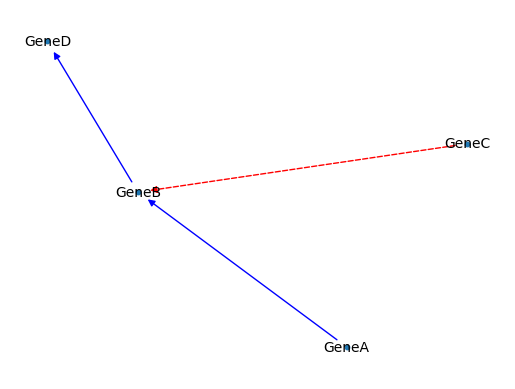

In [3]:
# create toy network
abcd_dag = nx.DiGraph()
abcd_dag.add_node('GeneA', value=10.0)  
abcd_dag.add_node('GeneB', value=0.0)
abcd_dag.add_node('GeneC', value=10.0)  
abcd_dag.add_node('GeneD', value=0.0)
abcd_dag.add_edge('GeneA', 'GeneB', interaction_type='activation')
abcd_dag.add_edge('GeneC', 'GeneB', interaction_type='repression')
abcd_dag.add_edge('GeneB', 'GeneD', interaction_type='activation')


# plot graph
# plot the network
G = abcd_dag
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=10)
activation_edges = [(u, v) for u, v, d in G.edges(data=True) if d['interaction_type'] == 'activation']
repression_edges = [(u, v) for u, v, d in G.edges(data=True) if d['interaction_type'] == 'repression']
nx.draw_networkx_edges(G, pos, edgelist=activation_edges, edge_color='blue', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=repression_edges, edge_color='red', arrows=True, style='dashed')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
plt.axis('off')
plt.show()



In [74]:
# set parameters for Hill equation
hill_parameters = {
    'beta_GeneA_to_GeneB': 0.5,
    'K_GeneA_to_GeneB': 2,
    'n_GeneA_to_GeneB': 2,
    'beta_GeneC_to_GeneB': 0.3,
    'K_GeneC_to_GeneB': 3,
    'n_GeneC_to_GeneB': 1,
    'beta_GeneB_to_GeneD': 0.4,
    'K_GeneB_to_GeneD': 4,
    'n_GeneB_to_GeneD': 3
}


# Create SBML file
model_name = "ABCD_model"
sbml_filename = model_name + ".xml"
utility.create_sbml_model_from_nx(G, sbml_filename, hill_params=hill_parameters)  # networkx to SBML
print(te.getODEsFromSBMLFile(sbml_filename))



SBML model written to ABCD_model.xml

vJ_GeneA_to_GeneB = 0.5*pow(GeneA,n_GeneA_to_GeneB)/(pow(K_GeneA_to_GeneB,n_GeneA_to_GeneB)+pow(GeneA,n_GeneA_to_GeneB))
vJ_GeneB_to_GeneD = 0.4*pow(GeneB,n_GeneB_to_GeneD)/(pow(K_GeneB_to_GeneD,n_GeneB_to_GeneD)+pow(GeneB,n_GeneB_to_GeneD))
vJ_GeneC_to_GeneB = 0.3/(1+pow(GeneC,n_GeneC_to_GeneB)/3)

dGeneA/dt = -vJ_GeneA_to_GeneB
dGeneB/dt = vJ_GeneA_to_GeneB - vJ_GeneB_to_GeneD + vJ_GeneC_to_GeneB
dGeneC/dt = -vJ_GeneC_to_GeneB
dGeneD/dt = vJ_GeneB_to_GeneD



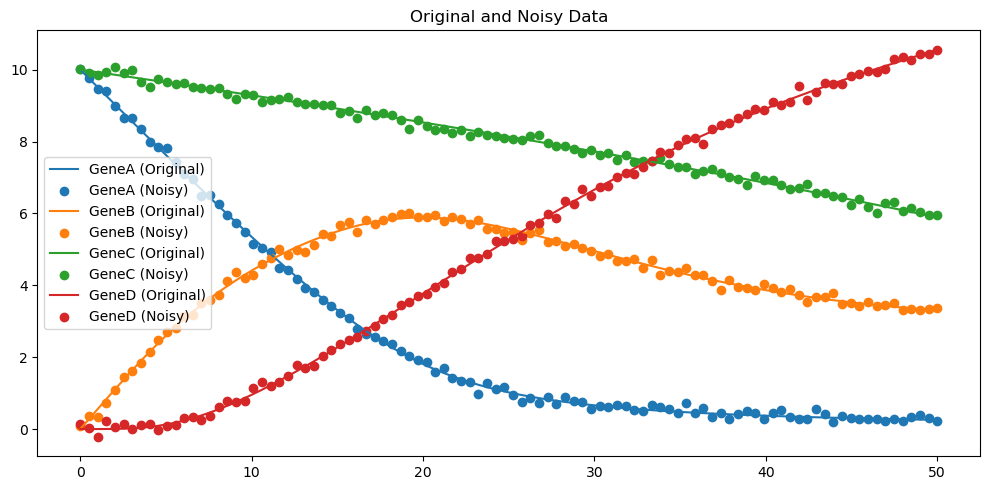

In [81]:
# Load and simulate the model
rr_model = te.loadSBMLModel(sbml_filename)
rr_results = rr_model.simulate(0, 50, 100, selections=['time', '[GeneA]', '[GeneB]', '[GeneC]', '[GeneD]'])


# format, add noise 
rr_results_df = pd.DataFrame(rr_results, columns=rr_results.colnames)
rr_results_df = rr_results_df.set_index('time')
rr_results_df.index.names = ['Timestamp']  # must be 'Timestamp' for pyciemss
rr_results_df.columns = rr_results_df.columns.str.replace('[', '', regex=False).str.replace(']', '', regex=False)

rr_results_df_noisy = rr_results_df.copy()
noise = np.random.normal(0, 0.1, rr_results_df.shape)
rr_results_df_noisy += noise


# plot
fig, ax = plt.subplots(figsize=(10, 5))
for column in rr_results_df.columns:
    ax.plot(rr_results_df.index, rr_results_df[column], label=f'{column} (Original)', linestyle='-')
    ax.scatter(rr_results_df_noisy.index, rr_results_df_noisy[column], label=f'{column} (Noisy)', marker='o')

ax.set_title('Original and Noisy Data')
ax.legend()
plt.tight_layout()
plt.show() 

# save data
rr_data_filepath = model_name + "_data.csv"
rr_data_filepath_noisy = model_name + "_noisy_data.csv"
rr_results_df.to_csv(rr_data_filepath)
rr_results_df_noisy.to_csv(rr_data_filepath_noisy)

# create a causal probablistic model

This type of model is well-suited to Bayesian/Causal inference, performing interventions/pertubations on data

procedure:
- convert SBML into a 'template (meta) model' using MIRA
- assign priors on the model parameters (this could be done from SBML)
- save as a petri net model to use in pyciemss (probablistic causal inference for dynamic systems models)

Matrix([
[                                                                                                                                  -0.5*GeneA**n_GeneA_to_GeneB/(GeneA**n_GeneA_to_GeneB + K_GeneA_to_GeneB**n_GeneA_to_GeneB)],
[0.5*GeneA**n_GeneA_to_GeneB/(GeneA**n_GeneA_to_GeneB + K_GeneA_to_GeneB**n_GeneA_to_GeneB) - 0.4*GeneB**n_GeneB_to_GeneD/(GeneB**n_GeneB_to_GeneD + K_GeneB_to_GeneD**n_GeneB_to_GeneD) + 0.3/(GeneC**n_GeneC_to_GeneB/3 + 1)],
[                                                                                                                                   0.4*GeneB**n_GeneB_to_GeneD/(GeneB**n_GeneB_to_GeneD + K_GeneB_to_GeneD**n_GeneB_to_GeneD)],
[                                                                                                                                                                                         -0.3/(GeneC**n_GeneC_to_GeneB/3 + 1)]])

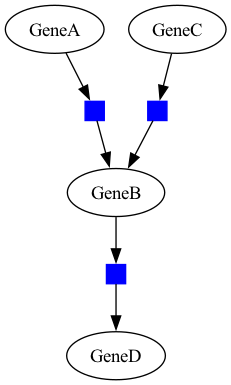

In [82]:
mira_model = template_model_from_sbml_file(sbml_filename)

# assign priors for the model parameters
for name,parameter in mira_model.parameters.items():
    if name != "default_compartment":
        parameter.distribution = Distribution(type="Uniform1", parameters={"minimum": 0.1, "maximum": 3})

# display(mira_model.parameters)
# display(mira_model.initials)

petrinet_model_filename = model_name + '_petrinet_w_priors.json'
file_root = Path(petrinet_model_filename).stem
petrinet_model = AMRPetriNetModel(Model(mira_model))
petrinet_model.to_json_file(
                petrinet_model_filename,
                name=file_root,
                description=file_root,
                indent=2,
            )

om = OdeModel(Model(mira_model), initialized=False)
display(om.get_interpretable_kinetics())
display(GraphicalModel.for_jupyter(mira_model))


# simulating a model in pyciemss - parameter sensitivity

Sampling from the prior distributions for the Hill equation parameters, we see a large variance in outcomes for different parameter values 

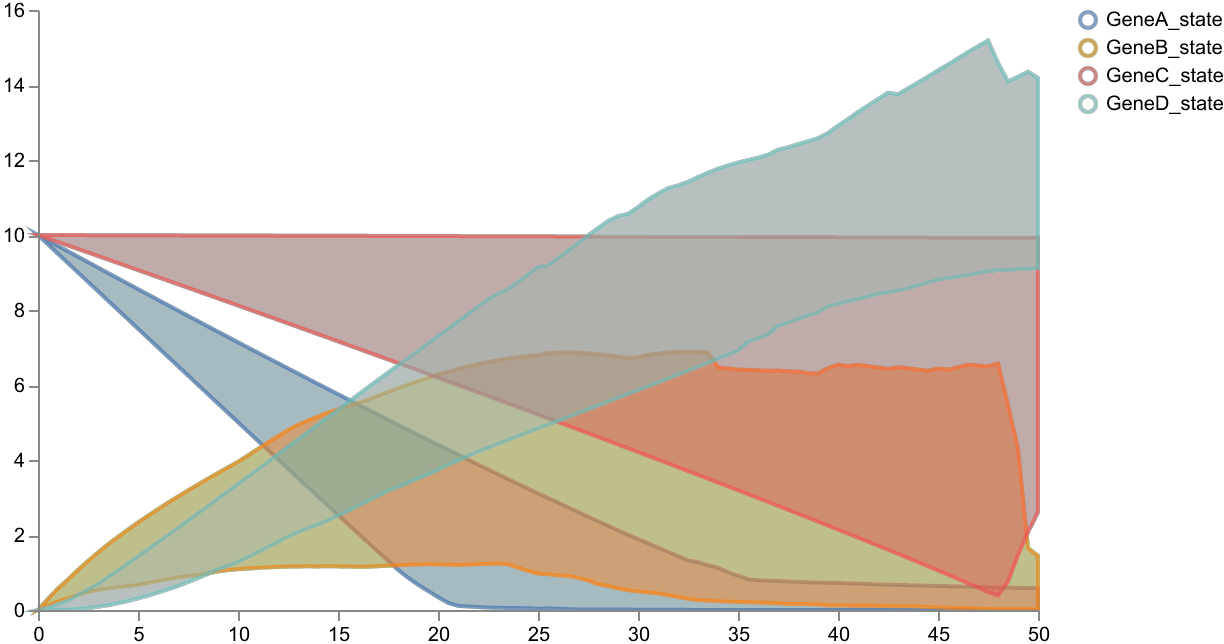

In [83]:
start_time = 0.0
end_time = 50
logging_step_size = 0.5
num_samples = 100


petrinet_results = pyciemss.sample(petrinet_model_filename, end_time, logging_step_size, num_samples, start_time=start_time, solver_method='euler', solver_options={'step_size':0.01})


# Plot results for all states
schema = plots.trajectories(petrinet_results["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)

# calibrating the model to data

Fit the parameters of the Hill equations to the noisy simulated data

In [100]:
data_filepath = rr_data_filepath_noisy
num_iterations = 100
model_path_or_json = petrinet_model_filename
data_mapping = {k:k for k in rr_results_df_noisy.columns}  
start_time = 0.0

calibration_results = pyciemss.calibrate(model_path_or_json, data_filepath, data_mapping=data_mapping, 
                                         num_iterations=num_iterations, verbose=False, 
                                         start_time=start_time, 
                                         solver_method='euler', solver_options={'step_size':0.01})

/Users/geor228/miniconda3/envs/NOCAP_env/lib/python3.11/site-packages/pyciemss/integration_utils/observation.py:49: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Data printout: This dataset contains 99 rows of data. The first column, Timestamp, begins at 0.0 and ends at 50.0. The subsequent columns are named: GeneA, GeneB, GeneC, GeneD


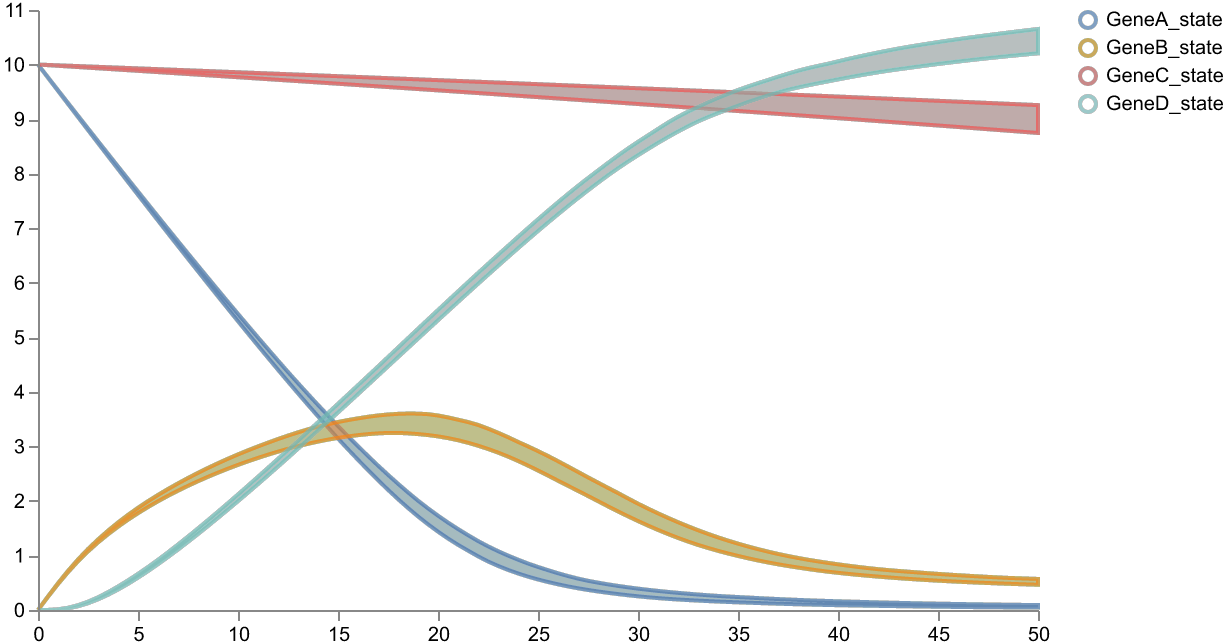

In [107]:
# set simulation and sampling parameters
start_time = 0.0
end_time = 50
logging_step_size = 0.5
num_samples = 100

parameter_estimates = calibration_results["inferred_parameters"]

calibrated_sample_results = pyciemss.sample(petrinet_model_filename, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates, solver_method='euler', solver_options={'step_size':0.01})

schema = plots.trajectories(calibrated_sample_results["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)

# interventions

At t=25 we intervene and set GeneA back to 10, which results in a ~50% increase in the amount of GeneD vs no intervention

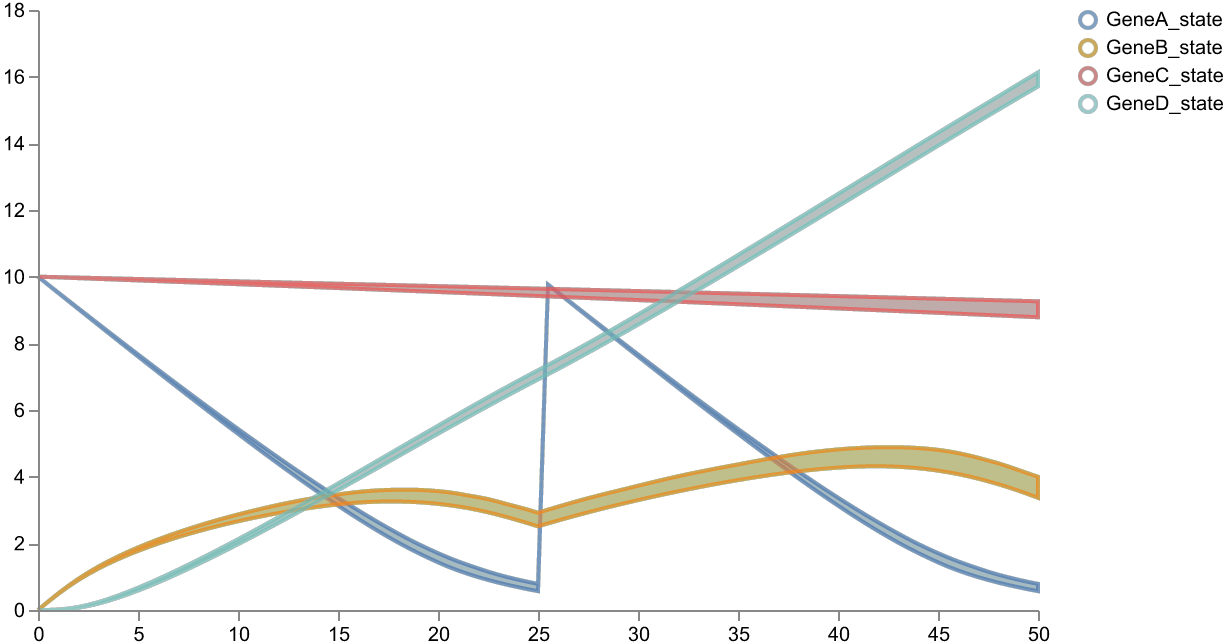

In [113]:
import torch

intervened_calibrated_sample_results = pyciemss.sample(petrinet_model_filename, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates, solver_method='euler', solver_options={'step_size':0.01}, 
                static_state_interventions={torch.tensor(25.0): {'GeneA':torch.tensor(10.0)}})

schema = plots.trajectories(intervened_calibrated_sample_results["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)

# next steps
- integrating perturb-seq data into model 
- optimization -  e.g. which set of pertubations yields the 'best' outcome? what other analysis would be helpful?